#   K-Nearest Neighbors (KNN) and Appriximatly Nearest Neighbors (ANN) Implementation

## Description
Implementattion form scratch of K-Nearest Neighbors(KNN) and Appriximatly Nearest Neighbors(ANN) algorithms.
I matched feature points on images using ANN method: Locality Sensitive Hashing (LSH) and compared ANN results with KNN results demonstrate which of the hyperparamters of the ANN method gives the best results (quality and performance).
I also compared the Sklearn NearestNeighbors algorithm results using the KD Tree modelour ANN results with our KNN results .

In [1]:
import numpy as np
import pandas as pd
import math
import operator 
import scipy.spatial
import time
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree

import PIL
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import image
import random
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from collections import namedtuple
from collections import Counter

## Download the data

### Hananya data set

In [2]:
Hananya_train = pd.read_csv('Hananya1.csv')
Hananya_train.head()

,Y,X,scale,angle,feature1,feature2,feature3,feature4,feature5,feature6,...,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128
0,191.63,281.10,20.79,1.545,65,7,0,0,0,0,...,0,7,0,0,0,0,1,1,0,0
1,195.73,41.28,6.35,1.458,52,12,0,0,12,4,...,1,18,0,0,0,0,0,0,5,0
2,196.50,150.37,9.14,1.441,60,15,1,1,2,6,...,0,1,7,0,0,0,0,0,0,2
3,198.02,23.67,1.93,1.870,72,9,0,0,1,2,...,23,48,7,0,0,0,0,0,1,10
4,198.24,24.35,1.71,1.845,80,20,0,0,0,0,...,26,53,9,1,0,0,0,0,0,15


In [3]:
Hananya_train.shape

(780, 132)

In [4]:
Hananya_test = pd.read_csv('Hananya2.csv')
Hananya_test.head()

,Y,X,scale,angle,feature1,feature2,feature3,feature4,feature5,feature6,...,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128
0,193.17,371.13,22.83,1.571,46,13,0,0,0,0,...,0,24,0,0,0,10,3,0,0,0
1,331.15,543.32,18.86,1.099,15,105,32,1,0,0,...,0,0,1,12,2,0,0,0,0,0
2,253.43,525.48,21.01,1.512,47,67,0,0,0,0,...,0,5,50,7,2,3,0,0,0,0
3,236.15,239.20,21.35,1.502,11,6,0,0,0,0,...,0,39,87,3,0,0,0,0,0,10
4,201.21,471.74,19.79,1.411,78,31,0,0,0,0,...,0,0,0,1,2,17,0,0,0,0


In [5]:
Hananya_test.shape

(913, 132)

In [12]:
x_train = Hananya_train.iloc[:, 4:].values
y_train = Hananya_train.iloc[:, :4].values
x_train

array([[65,  7,  0, ...,  1,  0,  0],
       [52, 12,  0, ...,  0,  5,  0],
       [60, 15,  1, ...,  0,  0,  2],
       ...,
       [18,  7,  1, ...,  4,  3,  0],
       [18, 10,  2, ...,  0,  0,  0],
       [28, 13, 24, ...,  0,  0,  0]], dtype=int64)

In [13]:
x_test = Hananya_test.iloc[:, 4:].values
y_test = Hananya_test.iloc[:, :4].values

## Normalize data
In order for all of the features to be mapped to the same range of values (between 0 and 1 ) for calculating the distance, the features need to be normalized.

In [14]:
def normalize(data):
    #normalize only the features
    feat_list=list(data)[4:]
    x=data[feat_list].values
    d=MinMaxScaler().fit_transform(x)
    data[feat_list] = pd.DataFrame(d,columns=feat_list)
    return data

## 1. KNN implementaion

In [15]:
class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, data):
        self.data=normalize(data)        
        
    # use scipy.spatial.distance.euclidean for calculating the Euclidean distance between two points   
    def distance(self, x1, x2):
        distance = scipy.spatial.distance.euclidean(x1, x2)
        return distance
        
    #Return k nearest neighbours for vector x
    def kneighbors(self, sample, k):
        neighbors = namedtuple('knn','point neighbors_list')
        #k=k or self.k
        
        k_nn=[]
        for row,point in sample.iterrows():
            distances = []
            # calculate distance for a test point and return neighbors          
            for row, data_point in self.data.iterrows():
                dist = self.distance(point[4:],data_point[4:])
                distances.append([dist,(data_point[0],data_point[1])])
            #most_common=self.best_nn(point,k) 
            distances=sorted(distances,key=lambda x: x[0])
            k_neighbors=distances[:k] #if len(distances)>=k else distances
            k_nn.append(neighbors(point=point,neighbors_list=k_neighbors))
        return k_nn 


In [16]:
# A function that finds the two nearst neighbors and calculate the ratio between the their distances
#If the ratio less than the threshold it will return the nearst neighbor
def match(train_set,test_set):
    #normalize test set
    test_set=normalize(test_set)    
    knn = KNN(2)
    #knn.fit(x_train, y_train)
    knn.fit(train_set)
    knn = knn.kneighbors(sample = test_set, k=2)
    

    match=[]
    for neighbor in knn:
        if len(neighbor.neighbors_list)<2:
            continue
        nearest =  neighbor.neighbors_list[0][0]
        seconed_nearest = neighbor.neighbors_list[1][0] 
        ratio=nearest/seconed_nearest
        threshold = 0.8
        if ratio<threshold:
            match.append((neighbor.point,neighbor.neighbors_list[0]))
    
    vaild_points=sorted(match,key=lambda x: x[1][0])
    return vaild_points

## 2. ANN - Locality Sensitive Hashing (LSH)

In [19]:
class LSH:
    def __init__(self,k_cuts,l_tabels,knn, feat_dim = 128):        
        self.k_cuts=k_cuts
        self.l_tabels=l_tabels
        self.knn=knn
        self.data=None
        # initiate hash tables
        self.hash_tables=[HashTable(self.k_cuts,feat_dim) for table in range(self.l_tabels)]
          
    def fit(self,data):
        #normalize data
        data=normalize(data=data)
        for hash_table in self.hash_tables:
            for row,point in data.iterrows():
                hash_table.add(point) 

    
    # use scipy.spatial.distance.euclidean for calculating the Euclidean distance between two points   
    def distance(self, x1, x2):
        return scipy.spatial.distance.euclidean(x1, x2)  
    
    #Return k nearest neighbours for vector x
    def kneighbors(self,sample,knn):
        neighbors = namedtuple('knn','point neighbors_list')
        #knn=knn or self.knn        
        k_nn=[]
        for row,point in sample.iterrows():
            most_common=self.best_nn(point,knn)       
            k_nn.append(neighbors(point=point,neighbors_list=most_common))
        return k_nn 
    
    # calculate distance for a test point and return k neighbors          
    def best_nn(self,point,knn):
        neighbors_list = []
        for hash_table in self.hash_tables:
            hash_keys=hash_table.get_keys(point)            
            distances=[(self.distance(point[4:],data[4:]),(data[0],data[1])) for data in hash_keys] 
            distances=sorted(distances,key=lambda x: x[0])
            
            neighbors=distances[:knn] if len(distances)>=knn else distances
            neighbors_list.extend(neighbors)
        most_common=[key for key,val in Counter(neighbors_list).most_common(knn)]
        most_common=sorted( most_common,key=lambda x: x[0])
        return  most_common      
                

        
class HashTable:
    def __init__(self,k_cuts,feat_dim):
        self.hush_table = defaultdict(list)
        #generate random cuts of the same dimensionality as our features 
        self.k_cuts=np.random.normal(size=(feat_dim,k_cuts))  
        
    # data points diveded into bins and encoded into keys
    #The bit is given by the sign of the dot product between the random vector and the document's vector.
    def keys(self,point):
        bin_index=(np.dot(point[4:],self.k_cuts)>=0).astype('int')  # display index bits in 0/1's
        # encode bin index bits into integers
        #powers_of_two = 1 << np.arange(k_cuts - 1, -1, step=-1)
        #bin_index = bin_index.dot(powers_of_two)
        return ''.join(bin_index.astype('str'))
        
    
    # update table with bin_index  
    def add(self,point):
        value=self.keys(point)
        self.hush_table[value].append(point)
    
    # return hush keys to a given point
    #if bin_index not in table, assign the bin an empty list
    def get_keys(self,point):
        value=self.keys(point)
        return self.hush_table.get(value,[])

In [20]:
# A function that finds the two nearst neighbors and calculate the ratio between the their distances
#If the ratio less than the threshold it will return the nearst neighbor

def match(train_set,test_set,k_cuts,l_tabels):
    #normalize test set
    test_set=normalize(test_set)    
    ann=LSH(k_cuts=k_cuts,l_tabels=l_tabels,knn=2)
    ann.fit(data=train_set)
    ann=ann.kneighbors(test_set,2)

    
    match=[]
    for neighbor in ann:
        if len(neighbor.neighbors_list)<2:
            continue
        nearest =  neighbor.neighbors_list[0][0]
        seconed_nearest = neighbor.neighbors_list[1][0] 
        ratio=nearest/seconed_nearest
        threshold = 0.8
        if ratio<threshold:
            match.append((neighbor.point,neighbor.neighbors_list[0]))
    
    vaild_points=sorted(match,key=lambda x: x[1][0])
    return vaild_points

## 3. Present  nearest neighbors on the images

In [21]:
# Drawing 10 best neares neighbors on the images
# Mark parallel pixels between the pairs
#Each pair of neighbors has a different color

def draw_points(vaild_points,first_image,second_image):
    img1,img2=Image.open(first_image),Image.open(second_image)
    draw1,draw2=ImageDraw.Draw(img1),ImageDraw.Draw(img2)
    
    #drawing only 10 points
    if len(vaild_points)>=10:
        num_vp=10 
    else:
        len(vaild_points)
    
    colors= ["red", "orange", "yellow", "green", "blue", "purple", "pink", "aqua", "black","white"]
        
    for point,color in zip(vaild_points[:num_vp],colors):
        dist, (y1,x1)=point[1]
        draw1.ellipse([x1-5,y1-5,x1+5,y1+5],fill=color,width=5)
        y2,x2=point[0][0],point[0][1]
        draw2.ellipse((x2-5,y2-5,x2+5,y2+5),fill=color,width=5)
      
    #show images       
    images = [img1,img2]
    for ima in images:
        plt.figure()
        plt.imshow(ima)             

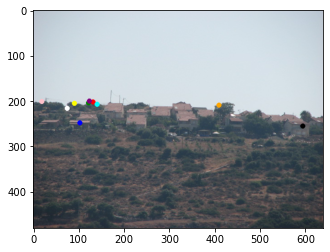

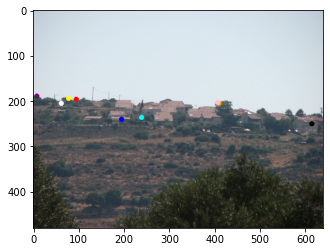

In [24]:
#choose optimal hyperparmaters (from section 6)  
k_cuts, l_tabels = 11,15
vaild_points = match(train_set = Hananya_train ,test_set = Hananya_test, k_cuts =k_cuts ,l_tabels = l_tabels)
draw_points(vaild_points,first_image = "Hananya1.jpg" ,second_image = "Hananya2.jpg")

### Conclusion:
I used the implemented ANN-LSH function to find the two nearst neighbors. If the ratio was less than the threshold it returned the nearst neighbor.
I run the ANN function with the optimal hyperparmaters we recived in section 6: k_cuts = 11 , l_tabels =15.
I used the pillow library to show the 10 best results of closet neighbors on the images, we marked parallel pixels between the pairs and presented each pair of neighbors with different color.
Looking at the results above, it can be indicated that 7 points out of 10 seems to be correct (red, orange, yellow, green, blue, black, white).The points which had diffrences due to errors in the ANN are the purple, pink and aqua points which probably returned similar neighbors.

## 4. Hyperparameters with optimal results (smallest error) using grid search

In [25]:
def grid_search():
    train_set = normalize(Hananya_train)
    test_set =  normalize(Hananya_test)
    # choices for Hyperparameters
    cuts = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    tabels = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60]
        best_epsilon = 100
    best_values = None
    epsilons = []
    
    #test_set = normalize(Hananya_test)
    knn = KNN(k=2)
    knn.fit(data=train_set)
    knn = knn.kneighbors(test_set, 2)
         
    for k_cuts in cuts:
        for l_tabels in tabels:
            print("checked:", (k_cuts, l_tabels))
            start = time.time()
            ann = LSH(k_cuts=k_cuts, l_tabels=l_tabels, knn=2)
            ann.fit(data=train_set)
            ann = ann.kneighbors(test_set, 2)
           
            sum = 0
            number_of_zero_neighobrs = 0
            for p in range(len(test_set)-1):
                #take care of cases were no neighbors are returned (due to high values of K_cuts)
                #not include in error calculation if no neighbors return 
                if len(ann[p].neighbors_list) == 0:
                    number_of_zero_neighobrs += 1
                else:
                    average_distances_ann = ann[p].neighbors_list[0][0] #+ ann[p].neighbors_list[1][0]
                    average_distances_knn = knn[p].neighbors_list[0][0] #+ knn[p].neighbors_list[1][0]
                    ratio = average_distances_ann/average_distances_knn - 1
                    sum += ratio
            # print(len(knn), sum)
            epsilon = (1/(len(knn)-number_of_zero_neighobrs)) * sum
            epsilons.append((k_cuts, l_tabels, epsilon, time.time()-start))
            if epsilon < best_epsilon:
                best_epsilon = epsilon
                best_values = (k_cuts, l_tabels)
            print(epsilons[-1])

    print("Available combinations : ", cuts, tabels)
    print("Best: k =", best_values[0], "l =", best_values[1])
    
    return epsilons

In [26]:
 epsilons = grid_search()

checked: (3, 5)
(3, 5, 0.01806179235739542, 91.72760820388794)
checked: (3, 10)
(3, 10, 0.007767239177153396, 165.98097610473633)
checked: (3, 15)
(3, 15, 0.0037900063340763476, 215.83789730072021)
checked: (3, 20)
(3, 20, 0.002053995448339726, 319.47285413742065)
checked: (3, 25)
(3, 25, 0.0022466498752725522, 406.4254117012024)
checked: (3, 30)
(3, 30, 0.0021093692543088633, 475.5161190032959)
checked: (3, 35)
(3, 35, 0.0004936119650008587, 574.4472434520721)
checked: (3, 40)
(3, 40, 0.0006834987618279781, 663.3787434101105)
checked: (3, 50)
(3, 50, 0.0003298296682516709, 885.3291306495667)
checked: (3, 60)
(3, 60, 0.00034216252040028566, 993.956916809082)
checked: (4, 5)
(4, 5, 0.035100014447317224, 45.16753530502319)
checked: (4, 10)
(4, 10, 0.011988642410646202, 133.6428153514862)
checked: (4, 15)
(4, 15, 0.010050047654482874, 159.08153414726257)
checked: (4, 20)
(4, 20, 0.007364640552815965, 183.3581178188324)
checked: (4, 25)
(4, 25, 0.006815884352461446, 224.005934715271)
check

### Conclusion:
For each Hyperparameter (number of cuts and hush tables), 10 values were selected:
k_cuts = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 
l_tables =[5, 10, 15, 20, 25, 30, 35, 40, 50, 60]

I used grid search to evaluate each combination of algorithm parameters: numbers of random vectors (cuts) and different numbers of hush tables.
The parameters that lead to the optimal result (by the smallest error) are:

k_cuts = 3 
l_tables = 50
with an error of: 0.0003298 and run time of:885.329 sec

From the result, It can be seen that there is a trade-off between quality and performance: 
As the number of random vectors(k_cuts) increases, the error increases and the runtime decreases. This is since each bin contains less points on average. 
On the other hand, when using a small enough number of random vectors(k_cuts), LSH becomes very similar brute-force- error is smaller and the runtime increase. This also happens when the number of hush tabels increases.
From that reason, the optimal result with the smallest error was the combination with the smallest number of cuts and the highst number of tables.

## 5. 5 fastest pairs of parameters with error < 0.1  

In [27]:
# all parameters with error < 0.1 
epsilons_low = [x for x in epsilons if x[2] < 0.1]
#sort by runtime
epsilons_low = sorted(epsilons_low, key = lambda x: x[3])
#select 5 pairs of parameters
fastest = epsilons_low[:5]
print(fastest)

[(11, 15, 0.09942057294105225, 10.156452417373657), (12, 20, 0.0960936882525219, 11.723976612091064), (11, 20, 0.08269562549605616, 13.987732887268066), (7, 5, 0.08471579962217346, 15.715025663375854), (10, 15, 0.08666785089432644, 16.33049249649048)]


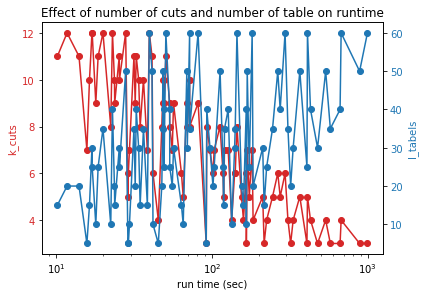

In [72]:
#plot all pairs
fig, ax1 = plt.subplots()
ax1.set_xlabel('run time (sec)')

ax1.set_ylabel('k_cuts', color='tab:red')
ax1.plot([x[3] for x in epsilons_low], [x[0] for x in epsilons_low], color='tab:red')
ax1.scatter([x[3] for x in epsilons_low], [x[0] for x in epsilons_low], color='tab:red')

ax1.set_xscale('log')

ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('l_tabels', color='tab:blue')
ax2.plot([x[3] for x in epsilons_low], [x[1] for x in epsilons_low], color='tab:blue')
ax2.scatter([x[3] for x in epsilons_low], [x[1] for x in epsilons_low], color='tab:blue')

ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xscale('log')

fig.tight_layout()
plt.title("Effect of number of cuts and number of table on runtime")

plt.show()

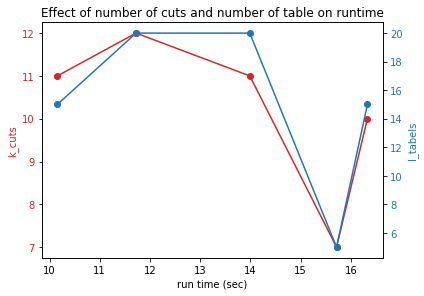

In [71]:
#plot 5 fastest pairs
fig, ax1 = plt.subplots()
ax1.set_xlabel('run time (sec)')

ax1.set_ylabel('k_cuts', color='tab:red')
ax1.plot([x[3] for x in fastest], [x[0] for x in fastest], color='tab:red')
ax1.scatter([x[3] for x in fastest], [x[0] for x in fastest], color='tab:red')

ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('l_tabels', color='tab:blue')
ax2.plot([x[3] for x in fastest], [x[1] for x in fastest], color='tab:blue')
ax2.scatter([x[3] for x in fastest], [x[1] for x in fastest], color='tab:blue')

ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title("Effect of number of cuts and number of table on runtime")
plt.show()

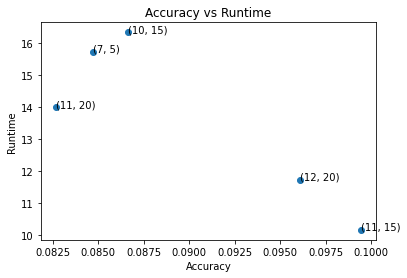

In [59]:
#plot accuracy vs time of 5 fastes pairs
accuracy_reault = []
runtime_result =[]
n=[]

for result in fastest:
    accuracy_reault.append(result[2])
    runtime_result.append(result[3])
    n.append((result[0], result[1]))

plt.scatter(accuracy_reault, runtime_result)


for i, txt in enumerate(n):
    plt.annotate(txt, (accuracy_reault[i], runtime_result[i]))

plt.xlabel("Accuracy")
plt.ylabel("Runtime")
plt.title("Accuracy vs Runtime")
plt.show()

### Conclusion:
The 5 pairs of parameters for which the error is less than 0.1 and the ANN algorithm runs the fastest are:
1. k_cuts = 11, l_tables = 15
2. k_cuts =9, l_tables =10
3. k_cuts =12, l_tables =25
4. k_cuts =8, l_tables =10 
5. k_cuts =12, l_tables =30

It can be seen from the figurs above that the optimal combination for error<0.1 and fastest performance is:
k_cuts = 11, l_tables = 15.
These paramters have:
Error: 0.0994
Runtime :10.1564 sec

The figure above shows the trade-off between quality and performance as explained in details in section 4:
As the number of random vectors(k_cuts) increases, the error is bigger and the runtime decreases and as the number of hush tabels increases the runtime also increases. 
Therfore in order to keep error < 0.1 for fastest run time- the number of tables should be small and the number of cuts high. In higher runtimes, the number of tables increases and the number of cuts decreases.

## 6. Comparing our model with scikit-learn

In [51]:
def error(k_nn, a_nn):
    sum = 0
    for p in range(len(test_set)):
        dist_ann = a_nn[0][p][0]
        dist_knn = k_nn[p].neighbors_list[0][0]
        ratio = dist_ann/dist_knn - 1
        sum += ratio
        epsilon = (1/len(k_nn)) * sum
    return epsilon

def compare():
    leaf_size = [ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 ]
    train_set = normalize(Hananya_train)
    test_set =  normalize(Hananya_test)    
    best_acuuracy = 0
    best_runtime = 1000
    best_values = None
    results = []
    knn = KNN(k=2)
    knn.fit(data=train_set)
    k_nn = knn.kneighbors(test_set, 2)
         
    for leaf in leaf_size:
        print("checked:", (leaf))
        start = time.time()
        #Sklearn NearestNeighbors
        nbrs=NearestNeighbors(n_neighbors=2,algorithm='kd_tree', leaf_size=leaf,metric='euclidean', p=2)
        nbrs.fit(train_set.iloc[:, 4:])
        a_nn=nbrs.kneighbors(test_set.iloc[:, 4:],2)
        runtime=time.time()-start
        acuuracy = 1- error(k_nn, a_nn)
        results.append((leaf, acuuracy, runtime))
        if acuuracy > best_acuuracy:
            best_acuuracy = acuuracy
        if runtime < best_runtime:
            best_runtime = runtime
            best_values = leaf
        print(results[-1])

    print("Best: best_values= ", best_values)
    print("Best: best_acuuracy= ", best_acuuracy)
    print("Best: best_runtime= ", best_runtime)
    return results

In [52]:
compare_results = compare()

checked: 5
(5, 1.0, 0.5377812385559082)
checked: 10
(10, 1.0, 0.28125548362731934)
checked: 15
(15, 1.0, 0.18357157707214355)
checked: 20
(20, 1.0, 0.18735980987548828)
checked: 25
(25, 1.0, 0.14864706993103027)
checked: 30
(30, 1.0, 0.14563894271850586)
checked: 35
(35, 1.0, 0.15057015419006348)
checked: 40
(40, 1.0, 0.14964556694030762)
checked: 45
(45, 1.0, 0.14556503295898438)
checked: 50
(50, 1.0, 0.12066817283630371)
Best: best_values=  50
Best: best_acuuracy=  1.0
Best: best_runtime=  0.12066817283630371


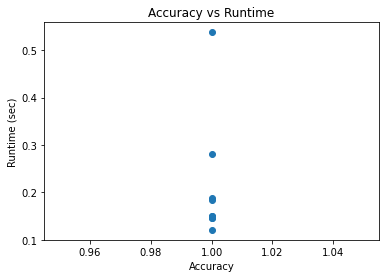

In [53]:
#plot Accuracy vs Runtime
accuracy_reaults = []
runtime_results =[]

for result in compare_results:
    accuracy_reaults.append(result[1])
    runtime_results.append(result[2])

plt.scatter(accuracy_reaults, runtime_results)
plt.xlabel("Accuracy")
plt.ylabel("Runtime (sec)")
plt.title("Accuracy vs Runtime")
plt.show()

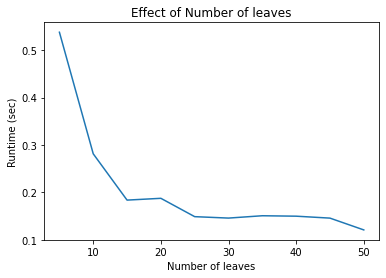

In [60]:
# plot Effect of Number of leaves on runtime
plt.plot([x[0] for x in compare_results], [x[2] for x in compare_results])
plt.xlabel("Number of leaves")
plt.ylabel("Runtime (sec)")
plt.title("Effect of Number of leaves")
plt.show()

### Conclusion:
I run the corresponding algorithm NearestNeighbors in Sklearn using the KD Tree model. I optimized the model for leaf parameter using grid search. 
As it can be seen from the figure above, the accurecy was 1 for all number of leaves. However, as the number of leaves increased, the runtime decreased. Therfore the most optimal paramter will be 50 leaves.

Comperasson of the Sklearn results (accuracy and runtime) with the best result we got in section 6:

Sklearn:
- best acuuracy=  1.0
- best runtime=  0.115 sec

Implemented ANN model: 
- best_acuuracy=  0.910
- best_runtime=  10.067 sec

